In [ ]:
import os
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2

import mediapipe as mp

### choose dataset by commenting/uncommenting

# # DDD dataset
# path = '/home/dimoik/Downloads/data/DDD/'
# suffix = 'ddd'

# nthuddd2 dataset
path = r"C:\Users\n\Desktop\projet ia\data1\FATIGUE"
suffix ="phot"

In [2]:
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(min_detection_confidence=0.3, min_tracking_confidence=0.8)
mp_drawing = mp.solutions.drawing_utils 
drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)

In [3]:
right_eye = [[33, 133], [160, 144], [159, 145], [158, 153]] # right eye landmark positions
left_eye = [[263, 362], [387, 373], [386, 374], [385, 380]] # left eye landmark positions
mouth = [[61, 291], [39, 181], [0, 17], [269, 405]] # mouth landmark coordinates

In [4]:
def distance(p1, p2):
    return (((p1[:2] - p2[:2])**2).sum())**0.5

def eye_aspect_ratio(landmarks, eye):
    N1 = distance(landmarks[eye[1][0]], landmarks[eye[1][1]])
    N2 = distance(landmarks[eye[2][0]], landmarks[eye[2][1]])
    N3 = distance(landmarks[eye[3][0]], landmarks[eye[3][1]])
    D = distance(landmarks[eye[0][0]], landmarks[eye[0][1]])
    return (N1 + N2 + N3) / (3 * D)

def eye_feature(landmarks):
    return (eye_aspect_ratio(landmarks, left_eye) + eye_aspect_ratio(landmarks, right_eye))/2

def mouth_feature(landmarks):
    N1 = distance(landmarks[mouth[1][0]], landmarks[mouth[1][1]])
    N2 = distance(landmarks[mouth[2][0]], landmarks[mouth[2][1]])
    N3 = distance(landmarks[mouth[3][0]], landmarks[mouth[3][1]])
    D = distance(landmarks[mouth[0][0]], landmarks[mouth[0][1]])
    return (N1 + N2 + N3)/(3*D)

In [5]:
drowsy_feats = []
drowsy_path = os.path.join(path, "drowsy")

# Check if directory exists
if not os.path.exists(drowsy_path):
    print(f"Directory {drowsy_path} does not exist.")
else:
    drowsy_list = os.listdir(drowsy_path)
    print(f"Total images in drowsy directory: {len(drowsy_list)}")

    for name in drowsy_list:
        image_path = os.path.join(drowsy_path, name)
        image = cv2.imread(image_path)
        
        # Check if image was loaded successfully
        if image is None:
            print(f"Could not read image {image_path}. Skipping.")
            continue

        # Flip and convert the image to RGB
        image_rgb = cv2.cvtColor(cv2.flip(image, 1), cv2.COLOR_BGR2RGB)
        
        # Process the image with face mesh
        results = face_mesh.process(image_rgb)

        if results.multi_face_landmarks:
            landmarks_positions = []
        # assume that only face is present in the image
            for _, data_point in enumerate(results.multi_face_landmarks[0].landmark):
                landmarks_positions.append([data_point.x, data_point.y, data_point.z]) # saving normalized landmark positions
            landmarks_positions = np.array(landmarks_positions)
            landmarks_positions[:, 0] *= image.shape[1]
            landmarks_positions[:, 1] *= image.shape[0]

            ear = eye_feature(landmarks_positions)
            mar = mouth_feature(landmarks_positions)
            drowsy_feats.append((ear, mar))
        else:
            continue

    # Convert features list to numpy array and save to a file
    drowsy_feats = np.array(drowsy_feats)
    output_path = os.path.join("./feats", f"{suffix}_mp_drowsy_feats.pkl")
    os.makedirs(os.path.dirname(output_path), exist_ok=True)

    with open(output_path, "wb") as fp:
        pickle.dump(drowsy_feats, fp)

    print(f"Feature extraction complete. Saved to {output_path}")

Total images in drowsy directory: 22348
Feature extraction complete. Saved to ./feats\phot_mp_drowsy_feats.pkl


In [6]:
with open("./feats\phot_mp_drowsy_feats.pkl", "rb") as fp:

    drowsy_feats = pickle.load(fp)

In [8]:
not_drowsy_feats = []
not_drowsy_path = os.path.join(path, "notdrowsy")

# Check if directory exists
if not os.path.exists(not_drowsy_path):
    print(f"Directory {not_drowsy_path} does not exist.")
else:
    not_drowsy_list = os.listdir(not_drowsy_path)
    print(f"Total images in notdrowsy directory: {len(not_drowsy_list)}")

    for name in not_drowsy_list:
        image_path = os.path.join(not_drowsy_path, name)
        image = cv2.imread(image_path)
        
        # Check if image was loaded successfully
        if image is None:
            print(f"Could not read image {image_path}. Skipping.")
            continue

        # Flip and convert the image to RGB
        image_rgb = cv2.cvtColor(cv2.flip(image, 1), cv2.COLOR_BGR2RGB)
        
        # Process the image with face mesh
        results = face_mesh.process(image_rgb)

        if results.multi_face_landmarks:
            landmarks_positions = []
        # assume that only face is present in the image
            for _, data_point in enumerate(results.multi_face_landmarks[0].landmark):
                landmarks_positions.append([data_point.x, data_point.y, data_point.z]) # saving normalized landmark positions
            landmarks_positions = np.array(landmarks_positions)
            landmarks_positions[:, 0] *= image.shape[1]
            landmarks_positions[:, 1] *= image.shape[0]

            ear = eye_feature(landmarks_positions)
            mar = mouth_feature(landmarks_positions)
            not_drowsy_feats.append((ear, mar))
        else:
            continue

    # Convert features list to numpy array and save to a file
    not_drowsy_feats = np.array(not_drowsy_feats)
    output_path = os.path.join("./feats", f"{suffix}_mp_not_drowsy_feats.pkl")
    os.makedirs(os.path.dirname(output_path), exist_ok=True)

    with open(output_path, "wb") as fp:
        pickle.dump(not_drowsy_feats, fp)

    print(f"Feature extraction complete. Saved to {output_path}")

Total images in notdrowsy directory: 19445
Feature extraction complete. Saved to ./feats\phot_mp_not_drowsy_feats.pkl


In [9]:
with open("./feats\phot_mp_not_drowsy_feats.pkl", "rb") as fp:
    non_drowsy_feats = pickle.load(fp)

### Data Statistics

In [10]:
print(f"Drowsy Images: {drowsy_feats.shape[0]}")
drowsy_ear = drowsy_feats[:, 0]
print(f"EAR | Min, Median, Mean, Max, SD: [{drowsy_ear.min()}, {np.median(drowsy_ear)}, {drowsy_ear.mean()}, {drowsy_ear.max()}, {drowsy_ear.std()}]")
drowsy_mar = drowsy_feats[:, 1]
print(f"MAR | Min, Median, Mean, Max, SD: [{drowsy_mar.min()}, {np.median(drowsy_mar)}, {drowsy_mar.mean()}, {drowsy_mar.max()}, {drowsy_mar.std()}]")

Drowsy Images: 22348
EAR | Min, Median, Mean, Max, SD: [0.05643663213581103, 0.23440516640901327, 0.23769841002149675, 0.4788618089840052, 0.06175599084484693]
MAR | Min, Median, Mean, Max, SD: [0.1579104064072938, 0.27007593084743897, 0.29444085404221526, 0.852751604533097, 0.07479365878783618]


In [11]:
print(f"Non Drowsy Images: {non_drowsy_feats.shape[0]}")
non_drowsy_ear = non_drowsy_feats[:, 0]
print(f"EAR | Min, Median, Mean, Max, SD: [{non_drowsy_ear.min()}, {np.median(non_drowsy_ear)}, {non_drowsy_ear.mean()}, {non_drowsy_ear.max()}, {non_drowsy_ear.std()}]")
non_drowsy_mar = non_drowsy_feats[:, 1]
print(f"MAR | Min, Median, Mean, Max, SD: [{non_drowsy_mar.min()}, {np.median(non_drowsy_mar)}, {non_drowsy_mar.mean()}, {non_drowsy_mar.max()}, {non_drowsy_mar.std()}]")

Non Drowsy Images: 19445
EAR | Min, Median, Mean, Max, SD: [0.0960194509125116, 0.26370564454608236, 0.2704957278714779, 0.4394997191869294, 0.047188973064084226]
MAR | Min, Median, Mean, Max, SD: [0.139104718407629, 0.2955462164966127, 0.30543910382658035, 0.5770066727463391, 0.06818546886870354]


### Classification

In [12]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, precision_recall_curve

In [15]:
s = 192
np.random.seed(s)
random.seed(s)

drowsy_labs = np.ones(drowsy_feats.shape[0])
non_drowsy_labs = np.zeros(non_drowsy_feats.shape[0])

X = np.vstack((drowsy_feats, non_drowsy_feats))
y = np.concatenate((drowsy_labs, non_drowsy_labs))

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.25, random_state=42)

In [16]:
mlp = MLPClassifier(hidden_layer_sizes=(5, 3), random_state=1, max_iter=1000)
mlp.fit(X_train, y_train)
mlp_preds = mlp.predict(X_test)
mlp_probas = mlp.predict_proba(X_test)

In [17]:
svm = SVC(probability=True)
svm.fit(X_train, y_train)
svm_preds = svm.predict(X_test)
svm_probas = svm.predict_proba(X_test)

In [18]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
rf_probas = rf.predict_proba(X_test)

#### Metrics

Accuracy, Precision, Recall, Sensitivity, Specificity, Macro Precision, Macro F1-Score

ROC, Precision-Recall

In [19]:
print("Classifier: RF")
preds = rf_preds
print(f"Accuracy: {accuracy_score(y_test, preds)}")
print(f"Precision: {precision_score(y_test, preds)}")
print(f"Macro Precision: {precision_score(y_test, preds, average='macro')}")
print(f"Recall: {recall_score(y_test, preds)}")
print(f"Macro F1 score: {f1_score(y_test, preds, average='macro')}")

Classifier: RF
Accuracy: 0.6812135132548569
Precision: 0.7006515231554851
Macro Precision: 0.6793614009907405
Recall: 0.7092691622103386
Macro F1 score: 0.6791399140903065


In [20]:
print("Classifier: MLP")
preds = mlp_preds
print(f"Accuracy: {accuracy_score(y_test, preds)}")
print(f"Precision: {precision_score(y_test, preds)}")
print(f"Macro Precision: {precision_score(y_test, preds, average='macro')}")
print(f"Recall: {recall_score(y_test, preds)}")
print(f"Macro F1 score: {f1_score(y_test, preds, average='macro')}")

Classifier: MLP
Accuracy: 0.6342233706574791
Precision: 0.7178362573099415
Macro Precision: 0.6489890506407863
Recall: 0.5251336898395722
Macro F1 score: 0.632404526982427


In [21]:
print("Classifier: SVM")
preds = svm_preds
print(f"Accuracy: {accuracy_score(y_test, preds)}")
print(f"Precision: {precision_score(y_test, preds)}")
print(f"Macro Precision: {precision_score(y_test, preds, average='macro')}")
print(f"Recall: {recall_score(y_test, preds)}")
print(f"Macro F1 score: {f1_score(y_test, preds, average='macro')}")

Classifier: SVM
Accuracy: 0.690879510000957
Precision: 0.7048898071625345
Macro Precision: 0.6891180343720451
Recall: 0.7297682709447415
Macro F1 score: 0.688198015126017


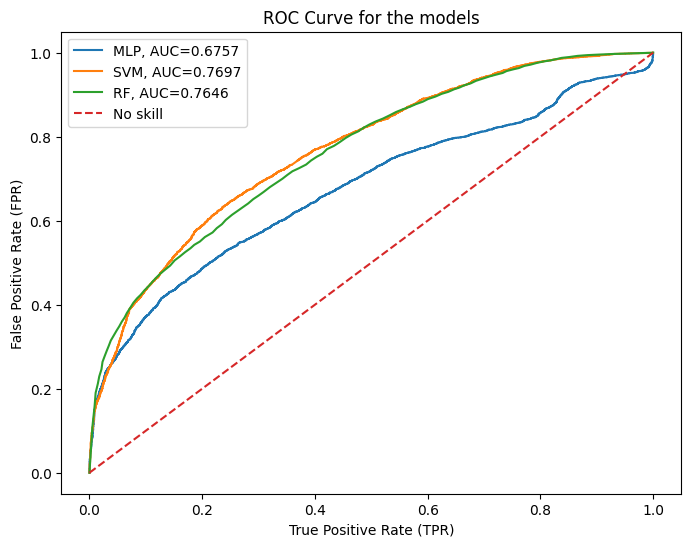

In [22]:
plt.figure(figsize=(8, 6))
plt.title("ROC Curve for the models")
# mlp
fpr, tpr, _ = roc_curve(y_test, mlp_probas[:, 1])
auc = round(roc_auc_score(y_test, mlp_probas[:, 1]), 4)
plt.plot(fpr, tpr, label="MLP, AUC="+str(auc))

# svm
fpr, tpr, _ = roc_curve(y_test, svm_probas[:, 1])
auc = round(roc_auc_score(y_test, svm_probas[:, 1]), 4)
plt.plot(fpr, tpr, label="SVM, AUC="+str(auc))

# RF
fpr, tpr, _ = roc_curve(y_test, rf_probas[:, 1])
auc = round(roc_auc_score(y_test, rf_probas[:, 1]), 4)
plt.plot(fpr, tpr, label="RF, AUC="+str(auc))

plt.plot(fpr, fpr, '--', label="No skill")
plt.legend()
plt.xlabel('True Positive Rate (TPR)')
plt.ylabel('False Positive Rate (FPR)')
plt.show()

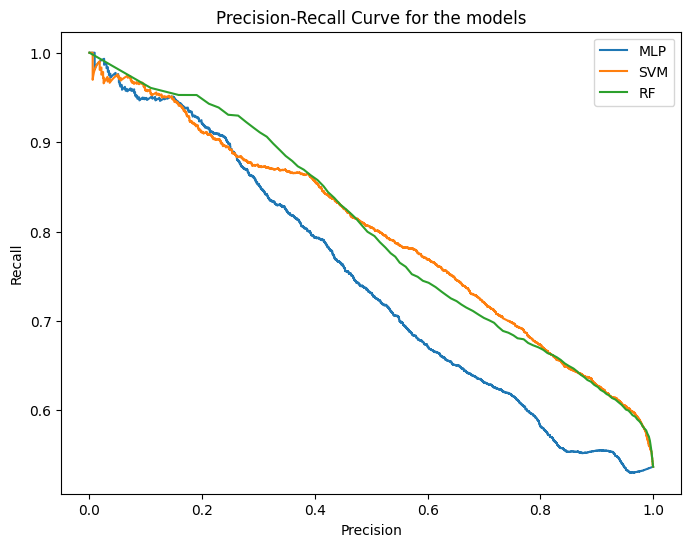

In [23]:
plt.figure(figsize=(8, 6))
plt.title("Precision-Recall Curve for the models")

# mlp
y, x, _ = precision_recall_curve(y_test, mlp_probas[:, 1])
plt.plot(x, y, label="MLP")

# svm
y, x, _ = precision_recall_curve(y_test, svm_probas[:, 1])
plt.plot(x, y, label="SVM")

# RF
y, x, _ = precision_recall_curve(y_test, rf_probas[:, 1])
plt.plot(x, y, label="RF")

plt.legend()
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.show()

KeyboardInterrupt: 

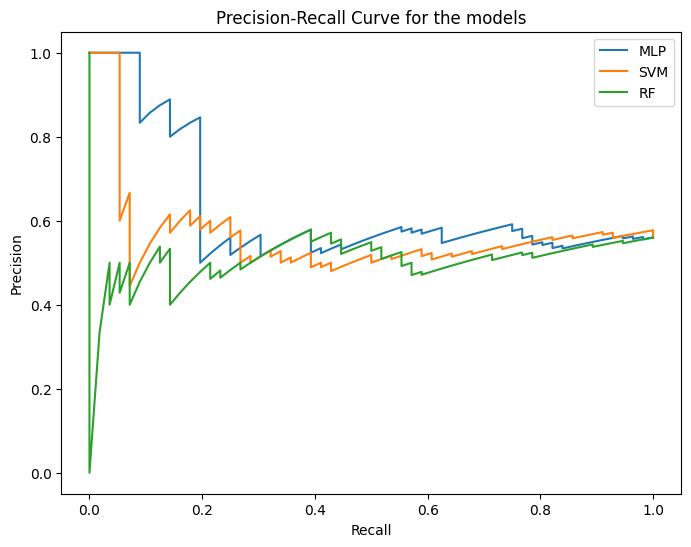

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
import numpy as np

def main():
    # Simuler des données fictives pour y_test et les probabilités des modèles
    np.random.seed(42)
    y_test = np.random.randint(0, 2, 100)  # Labels binaires
    mlp_probas = np.random.rand(100, 2)    # Probabilités du modèle MLP
    svm_probas = np.random.rand(100, 2)    # Probabilités du modèle SVM
    rf_probas = np.random.rand(100, 2)     # Probabilités du modèle RF

    # Tracer la courbe Precision-Recall
    plt.figure(figsize=(8, 6))
    plt.title("Precision-Recall Curve for the models")

    # MLP
    y, x, _ = precision_recall_curve(y_test, mlp_probas[:, 1])
    plt.plot(x, y, label="MLP")

    # SVM
    y, x, _ = precision_recall_curve(y_test, svm_probas[:, 1])
    plt.plot(x, y, label="SVM")

    # RF
    y, x, _ = precision_recall_curve(y_test, rf_probas[:, 1])
    plt.plot(x, y, label="RF")

    # Ajout des légendes et labels
    plt.legend()
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()

if __name__ == "__main__":
    main()


In [1]:
import os

# Créer un répertoire pour sauvegarder les modèles
os.makedirs("./models", exist_ok=True)

# Sauvegarder le modèle Random Forest
with open("./models/rf_model.pkl", "wb") as rf_file:
    pickle.dump(rf, rf_file)

# Sauvegarder le modèle SVM
with open("./models/svm_model.pkl", "wb") as svm_file:
    pickle.dump(svm, svm_file)

# Sauvegarder le modèle MLP
with open("./models/mlp_model.pkl", "wb") as mlp_file:
    pickle.dump(mlp, mlp_file)

print("Modèles sauvegardés avec succès dans le dossier './models'.")


NameError: name 'pickle' is not defined

In [7]:
import cv2
import mediapipe as mp
import numpy as np
import pygame
import pickle
import time

# Charger les modèles entraînés
with open("./feats/phot_mp_drowsy_feats.pkl", "rb") as fp:
    drowsy_feats = pickle.load(fp)
with open("./feats/phot_mp_not_drowsy_feats.pkl", "rb") as fp:
    non_drowsy_feats = pickle.load(fp)

# Charger le modèle SVM
with open("./models/svm_model.pkl", "rb") as svm_file:
    loaded_svm = pickle.load(svm_file)

print("Modèle chargé avec succès.")

# Initialisation des bibliothèques
pygame.init()
pygame.mixer.init()
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(min_detection_confidence=0.3, min_tracking_confidence=0.8)
mp_drawing = mp.solutions.drawing_utils

# Spécifications pour les points
right_eye = [[33, 133], [160, 144], [159, 145], [158, 153]]  # right eye
left_eye = [[263, 362], [387, 373], [386, 374], [385, 380]]  # left eye
mouth = [[61, 291], [39, 181], [0, 17], [269, 405]]  # mouth

# Fonction de calcul des distances
def distance(p1, p2):
    return np.sqrt(np.sum((p1[:2] - p2[:2])**2))

# Calcul EAR (Eye Aspect Ratio)
def eye_aspect_ratio(landmarks, eye):
    N1 = distance(landmarks[eye[1][0]], landmarks[eye[1][1]])
    N2 = distance(landmarks[eye[2][0]], landmarks[eye[2][1]])
    N3 = distance(landmarks[eye[3][0]], landmarks[eye[3][1]])
    D = distance(landmarks[eye[0][0]], landmarks[eye[0][1]])
    return (N1 + N2 + N3) / (3 * D)

# Calcul MAR (Mouth Aspect Ratio)
def mouth_feature(landmarks):
    N1 = distance(landmarks[mouth[1][0]], landmarks[mouth[1][1]])
    N2 = distance(landmarks[mouth[2][0]], landmarks[mouth[2][1]])
    N3 = distance(landmarks[mouth[3][0]], landmarks[mouth[3][1]])
    D = distance(landmarks[mouth[0][0]], landmarks[mouth[0][1]])
    return (N1 + N2 + N3) / (3 * D)

# Charger l'alerte sonore
alert_sound = r"C:\Users\n\Desktop\projet ia\alert.mp3"
pygame.mixer.music.load(alert_sound)

# Capturer le flux vidéo
cap = cv2.VideoCapture(0)

# Variables pour le timer
fatigue_start_time = None  # Temps où la fatigue commence à être détectée
fatigue_threshold = 3  # Temps en secondes avant déclenchement de l'alarme

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Préparer l'image pour MediaPipe
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = face_mesh.process(image)

    # Dessiner les résultats
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            landmarks_positions = []
            for data_point in face_landmarks.landmark:
                landmarks_positions.append([data_point.x, data_point.y, data_point.z])
            landmarks_positions = np.array(landmarks_positions)
            landmarks_positions[:, 0] *= frame.shape[1]
            landmarks_positions[:, 1] *= frame.shape[0]

            # Calculer EAR et MAR
            ear = (eye_aspect_ratio(landmarks_positions, left_eye) +
                   eye_aspect_ratio(landmarks_positions, right_eye)) / 2
            mar = mouth_feature(landmarks_positions)
            features = np.array([[ear, mar]])

            # Prédiction avec le modèle SVM
            pred = loaded_svm.predict(features)[0]

            # Gestion du timer pour la fatigue
            current_time = time.time()
            if pred == 1:  # Fatigue détectée
                if fatigue_start_time is None:
                    fatigue_start_time = current_time  # Démarrer le timer
                elif current_time - fatigue_start_time >= fatigue_threshold:
                    cv2.putText(image, "Fatigue detected!", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                    if not pygame.mixer.music.get_busy():
                        pygame.mixer.music.play()
            else:
                fatigue_start_time = None  # Réinitialiser si la fatigue n'est plus détectée

            # Affichage du statut
            if fatigue_start_time is None:
                cv2.putText(image, "Normal", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Afficher l'image
    cv2.imshow("Fatigue Detection", image)

    # Quitter avec la touche 'q'
    if cv2.waitKey(5) & 0xFF == ord('q'):
        break

# Libérer les ressources
cap.release()
cv2.destroyAllWindows()
pygame.mixer.quit()


Modèle chargé avec succès.


KeyboardInterrupt: 

In [4]:
import cv2
import mediapipe as mp
import numpy as np
import pygame
import pickle
import time
from tensorflow.keras.models import load_model

# Charger les modèles entraînés pour la fatigue
with open("./models/svm_model.pkl", "rb") as svm_file:
    loaded_svm = pickle.load(svm_file)
print("Modèle SVM chargé avec succès.")

# Charger le modèle CNN pour la détection de fumée
smoke_model = load_model("CNN_smoking_model.h5")
print("Modèle CNN de détection de fumée chargé avec succès.")

# Initialisation des bibliothèques
pygame.init()
pygame.mixer.init()
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(min_detection_confidence=0.3, min_tracking_confidence=0.8)
mp_drawing = mp.solutions.drawing_utils

# Spécifications pour les points
right_eye = [[33, 133], [160, 144], [159, 145], [158, 153]]  # right eye
left_eye = [[263, 362], [387, 373], [386, 374], [385, 380]]  # left eye
mouth = [[61, 291], [39, 181], [0, 17], [269, 405]]  # mouth

# Fonction de calcul des distances
def distance(p1, p2):
    return np.sqrt(np.sum((p1[:2] - p2[:2])**2))

# Calcul EAR (Eye Aspect Ratio)
def eye_aspect_ratio(landmarks, eye):
    N1 = distance(landmarks[eye[1][0]], landmarks[eye[1][1]])
    N2 = distance(landmarks[eye[2][0]], landmarks[eye[2][1]])
    N3 = distance(landmarks[eye[3][0]], landmarks[eye[3][1]])
    D = distance(landmarks[eye[0][0]], landmarks[eye[0][1]])
    return (N1 + N2 + N3) / (3 * D)

# Calcul MAR (Mouth Aspect Ratio)
def mouth_feature(landmarks):
    N1 = distance(landmarks[mouth[1][0]], landmarks[mouth[1][1]])
    N2 = distance(landmarks[mouth[2][0]], landmarks[mouth[2][1]])
    N3 = distance(landmarks[mouth[3][0]], landmarks[mouth[3][1]])
    D = distance(landmarks[mouth[0][0]], landmarks[mouth[0][1]])
    return (N1 + N2 + N3) / (3 * D)

# Charger l'alerte sonore
alert_sound = r"C:\Users\n\Desktop\projet ia\alert.mp3"
pygame.mixer.music.load(alert_sound)

# Capturer le flux vidéo
cap = cv2.VideoCapture(0)

# Variables pour le timer
fatigue_start_time = None  # Temps où la fatigue commence à être détectée
smoke_start_time = None  # Temps où la fumée commence à être détectée
detection_threshold = 3  # Temps en secondes avant déclenchement de l'alarme

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Préparer l'image pour MediaPipe
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = face_mesh.process(image)

    # Préparer l'image pour la détection de fumée
    resized_frame = cv2.resize(frame, (250, 250))  # Redimensionner à 250x250 comme attendu par le modèle
    normalized_frame = resized_frame / 255.0  # Normalisation
    smoke_prediction = smoke_model.predict(np.expand_dims(normalized_frame, axis=0))
    print("Smoke prediction output:", smoke_prediction)

    # Gestion des cas de sortie avec un seuil de 0.6 pour la fumée
    if len(smoke_prediction[0]) > 1:  # Multiclasses
        smoke_detected = smoke_prediction[0][1] > 0.6
    else:  # Binaire
        smoke_detected = smoke_prediction[0][0] > 0.6

    # Dessiner les résultats
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    fatigue_detected = False  # Variable pour déterminer si la fatigue est détectée

    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            landmarks_positions = []
            for data_point in face_landmarks.landmark:
                landmarks_positions.append([data_point.x, data_point.y, data_point.z])
            landmarks_positions = np.array(landmarks_positions)
            landmarks_positions[:, 0] *= frame.shape[1]
            landmarks_positions[:, 1] *= frame.shape[0]

            # Calculer EAR et MAR
            ear = (eye_aspect_ratio(landmarks_positions, left_eye) +
                   eye_aspect_ratio(landmarks_positions, right_eye)) / 2
            mar = mouth_feature(landmarks_positions)
            features = np.array([[ear, mar]])

            # Prédiction avec le modèle SVM
            pred = loaded_svm.predict(features)[0]

            # Gestion du timer pour la fatigue
            current_time = time.time()
            if pred == 1:  # Fatigue détectée
                fatigue_detected = True
                if fatigue_start_time is None:
                    fatigue_start_time = current_time  # Démarrer le timer
                elif current_time - fatigue_start_time >= detection_threshold:
                    cv2.putText(image, "Fatigue detected!", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
            else:
                fatigue_start_time = None  # Réinitialiser si la fatigue n'est plus détectée

            # Affichage du statut de la fatigue
            if fatigue_start_time is None:
                cv2.putText(image, "Normal", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Gestion du timer pour la fumée
    current_time = time.time()
    if smoke_detected:
        if smoke_start_time is None:
            smoke_start_time = current_time  # Démarrer le timer
        elif current_time - smoke_start_time >= detection_threshold:
            cv2.putText(image, "Smoke detected!", (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    else:
        smoke_start_time = None  # Réinitialiser si la fumée n'est plus détectée

    # Déclencher l'alerte si fatigue ou fumée est détectée après le délai
    if (fatigue_detected and fatigue_start_time is not None and 
        time.time() - fatigue_start_time >= detection_threshold) or \
       (smoke_detected and smoke_start_time is not None and 
        time.time() - smoke_start_time >= detection_threshold):
        if not pygame.mixer.music.get_busy():
            pygame.mixer.music.play()

    # Afficher l'image
    cv2.imshow("Fatigue and Smoke Detection", image)

    # Quitter avec la touche 'q'
    if cv2.waitKey(5) & 0xFF == ord('q'):
        break

# Libérer les ressources
cap.release()
cv2.destroyAllWindows()
pygame.mixer.quit()


Modèle SVM chargé avec succès.
Modèle CNN de détection de fumée chargé avec succès.
1/1 [==============================] - 1s 536ms/step
Smoke prediction output: [[0.41057175]]
1/1 [==============================] - 0s 83ms/step
Smoke prediction output: [[0.41294408]]
1/1 [==============================] - 0s 115ms/step
Smoke prediction output: [[0.41304362]]
1/1 [==============================] - 0s 103ms/step
Smoke prediction output: [[0.41237867]]
1/1 [==============================] - 0s 82ms/step
Smoke prediction output: [[0.41128415]]
1/1 [==============================] - 0s 92ms/step
Smoke prediction output: [[0.41146964]]
1/1 [==============================] - 0s 70ms/step
Smoke prediction output: [[0.41292167]]
1/1 [==============================] - 0s 93ms/step
Smoke prediction output: [[0.41265652]]
1/1 [==============================] - 0s 70ms/step
Smoke prediction output: [[0.41280264]]
1/1 [==============================] - 0s 65ms/step
Smoke prediction output: [[0.4129

KeyboardInterrupt: 